## Calculate Sentiment returns and perform return analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pandas.tseries.offsets import DateOffset
import edhec_risk_kit as erk

In [2]:
# Name control files as well as relevant columns to process data
out_col_S = ['Date','Ticker','TR_1M','Sentiment','S_Quintile']
control_S = pd.read_csv(r'C:\Users\B420615.STANLIB\Sentiment_Control.csv')
control_S = control_S['Files'].tolist()

In [ ]:
# create file of sentiment selection alpha scores for all periods and output
# Using improved append function that ensures proper date sorting and column matching
Sentiment_Score = erk.append_csv_files_by_date(
    file_list=control_S,
    file_path_template=r'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\{}.csv',
    output_columns=out_col_S,
    date_column='Date',
    date_format='%Y%m%d'
)

In [4]:
Sentiment_Score.head()

,Date,Ticker,TR_1M,Sentiment,S_Quintile
0,2005-10-31,AU US Equity,-7.87,-0.069356,2
1,2005-10-31,EMI SJ Equity,3.09,0.310000,5
2,2005-10-31,CML SJ Equity,-0.91,0.248088,4
3,2005-10-31,ELH SJ Equity,-7.30,0.345633,5
4,2005-10-31,HYP SJ Equity,2.72,0.261420,5


In [5]:
#Create a column that aligns future 1M returns with current selection (Future_TR)
Sentiment_Score['Future_TR'] = Sentiment_Score.groupby('Ticker')['TR_1M'].shift(-1)
Sentiment_Score = Sentiment_Score.sort_values(by=['Date'])
Alltime = list(set(Sentiment_Score['Date'])) # used set to eliminate duplicate values
output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Sentiment_Score.csv'
Sentiment_Score.to_csv(output_file_path, index=False)

In [6]:
Sentiment_Score.head()

,Date,Ticker,TR_1M,Sentiment,S_Quintile,Future_TR
0,2005-10-31,AU US Equity,-7.87,-0.069356,2,5.35
78,2005-10-31,RLO SJ Equity,9.22,-0.090305,2,10.87
77,2005-10-31,DTC SJ Equity,-4.30,-0.002651,3,13.53
76,2005-10-31,SAB SJ Equity,0.80,0.251160,5,-5.31
75,2005-10-31,TKG SJ Equity,0.48,-0.149880,2,3.98


In [7]:
#Create a "liquid portfolio to eliminate illiquid stocks (defined by mkt cap). 
#Merge the liquidity filter dataframe and eliminate rows that do not meet liquidity requirements
liquidity_filter = 0.25
Jalsh_wts = pd.read_csv(rf'C:\Users\B420615.STANLIB\JalshWeightsBBG.csv')
Jalsh_wts["Date"] = pd.to_datetime(Jalsh_wts["Date"])
Jalsh_wts.rename(columns={'ID':'Ticker'},inplace=True)
Jalsh_wts.head()


Sentiment_Score_liquid = Sentiment_Score.merge(Jalsh_wts, on=['Date','Ticker'],how='left')
Sentiment_Score_liquid.drop(Sentiment_Score_liquid[Sentiment_Score_liquid['id().weights'] < liquidity_filter].index, inplace = True)


output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Sentiment_Score_liquid.csv'
Sentiment_Score.to_csv(output_file_path, index=False)



In [20]:
Sentiment_Score_liquid.head()

,Date,Ticker,TR_1M,Sentiment,S_Quintile,Future_TR,id().weights,ID_BB_GLOBAL
0,2005-10-31,AU US Equity,-7.87,-0.069356,2,5.35,1.515414,BBG01HGVLP51
1,2005-10-31,RLO SJ Equity,9.22,-0.090305,2,10.87,0.385414,BBG000BFN0P0
3,2005-10-31,SAB SJ Equity,0.80,0.251160,5,-5.31,6.158361,BBG000CVBYQ2
4,2005-10-31,TKG SJ Equity,0.48,-0.149880,2,3.98,1.537425,BBG000MKC989
9,2005-10-31,HAR SJ Equity,-0.42,-0.122592,2,14.89,1.219339,BBG000BTZG27


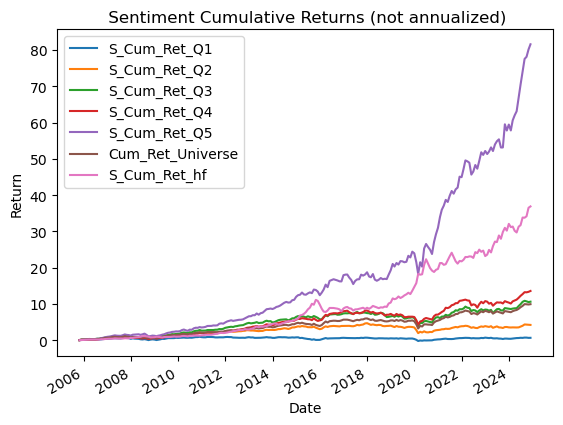

In [8]:
# Split data into quintiles, calculate quintile returns and graph quintile/universe performance - for Sentimentcomponent
averages = Sentiment_Score.groupby(['Date', 'S_Quintile'])['Future_TR'].mean().unstack(fill_value=0)
averages.reset_index(inplace=True)
averages.columns.name = None
averages.columns = ['Date','S_Q1','S_Q2','S_Q3','S_Q4','S_Q5']
Universe = Sentiment_Score.groupby(['Date'])['Future_TR'].mean()
averages = pd.merge(averages, Universe, on='Date', how='outer')
averages.rename(columns={'Future_TR':'Universe'},inplace=True)
averages['S_hf_returns'] = averages['S_Q5'] - averages['S_Q1']
averages['S_Cum_Ret_Q1'] = (1+averages['S_Q1']/100).cumprod()-1
averages['S_Cum_Ret_Q2'] = (1+averages['S_Q2']/100).cumprod()-1
averages['S_Cum_Ret_Q3'] = (1+averages['S_Q3']/100).cumprod()-1
averages['S_Cum_Ret_Q4'] = (1+averages['S_Q4']/100).cumprod()-1
averages['S_Cum_Ret_Q5'] = (1+averages['S_Q5']/100).cumprod()-1
averages['Cum_Ret_Universe'] = (1+averages['Universe']/100).cumprod()-1
averages['S_Cum_Ret_hf'] = ((1+averages['S_hf_returns']/100).cumprod()-1)

ax = averages.plot(xlabel='Date', ylabel='Return',x = 'Date',y = ['S_Cum_Ret_Q1','S_Cum_Ret_Q2','S_Cum_Ret_Q3','S_Cum_Ret_Q4','S_Cum_Ret_Q5','Cum_Ret_Universe','S_Cum_Ret_hf'])
ax.set_title(' Sentiment Cumulative Returns (not annualized)')

# Create a dataframe of average returns to be used to calculate the IC score
Ave_returns = averages[['Date', 'Universe']].copy()
# Create output file
output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Sentiment_Q_Scores.csv'
averages.to_csv(output_file_path, index=False)

In [9]:
#Create portfolios that include costs, interest plus liquidity filters

In [10]:
#Show annualised returns
last_row_series = ((1+(averages.iloc[-2][['S_Cum_Ret_Q1','S_Cum_Ret_Q2','S_Cum_Ret_Q3','S_Cum_Ret_Q4',
                                         'S_Cum_Ret_Q5','Cum_Ret_Universe','S_Cum_Ret_hf']]))**(12/229)-1)*100
last_row_series
#fig,ax = plt.subplots(figsize = (10,8))
#returns = sns.barplot(y = last_row_series,x = , color = sns.color_palette()[0],saturation=1.)

S_Cum_Ret_Q1         2.728044
S_Cum_Ret_Q2         9.055982
S_Cum_Ret_Q3        13.719589
S_Cum_Ret_Q4        15.079536
S_Cum_Ret_Q5        26.022976
Cum_Ret_Universe    13.358536
S_Cum_Ret_hf        20.981965
Name: 228, dtype: object

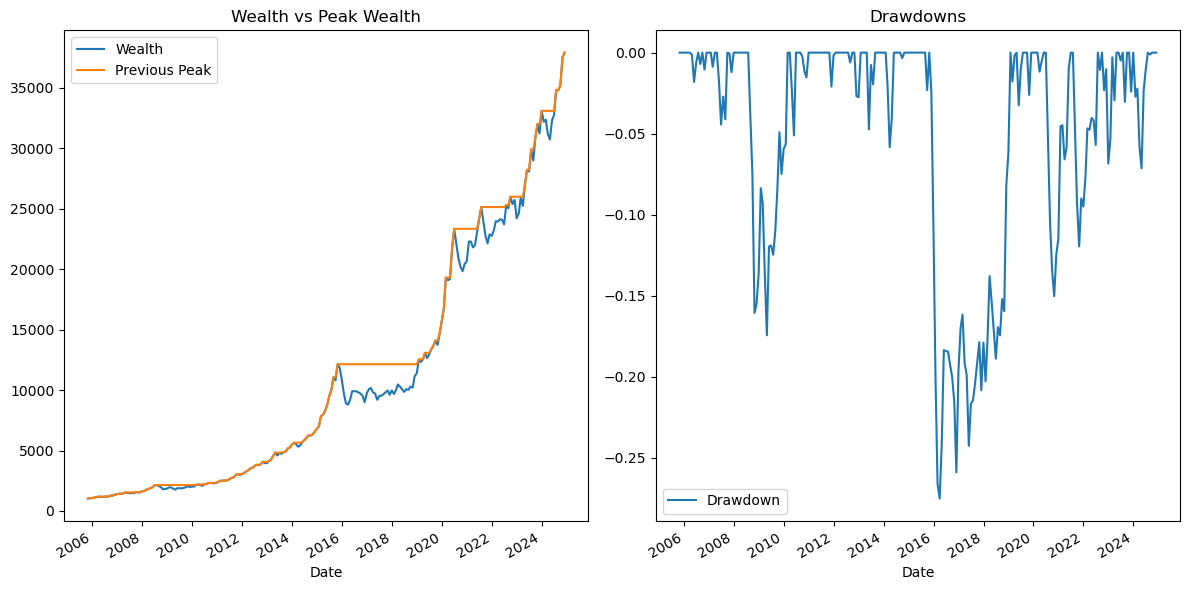

In [11]:
#Calculate drawdowns
Drawdowns = erk.drawdown(averages['S_hf_returns']/100)
Drawdowns = pd.merge(Drawdowns, averages['Date'], left_index=True,right_index=True)
Drawdowns = Drawdowns.reindex(['Date', 'Wealth', 'Previous Peak','Drawdown'], axis=1)
Drawdowns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
Drawdowns.plot(x='Date',y=['Wealth','Previous Peak'],ax=axes[0])
axes[0].set_title('Wealth vs Peak Wealth')

Drawdowns.plot(x='Date',y='Drawdown',ax=axes[1])
axes[1].set_title('Drawdowns')

plt.tight_layout()
plt.show()
                  
#ax = Drawdowns.plot(xlabel='Months', ylabel='Wealth',x='Date',y = ['Wealth','Previous Peak'])
#ax.set_title('Wealth vs Peak Wealth')


In [12]:
# Sharpe Ratio
erk.sharpe_ratio(averages['S_hf_returns']/100, 0, 12)

1.5021020416553108

In [13]:
#Isolate the long portfolio through time - output 'Longs' file
filtered_df = pd.DataFrame()
for date in Alltime:
    #Filter rows for the date and specified integer value
    temp_df = Sentiment_Score[(Sentiment_Score['Date'] == date) & (Sentiment_Score['S_Quintile'] == 5) ]
    filtered_df = pd.concat([filtered_df, temp_df], ignore_index=True)
    filtered_df = filtered_df.sort_values(by=['Date'])

output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Longs.csv'
filtered_df.to_csv(output_file_path, index=False)

In [14]:
def count_items_exceeding_value(df1, df2, date_column, value_column_df1, value_column_df2):
    """
    Counts the number of items in df1[value_column_df1] for each date
    that exceed the value of a single row item for the same date in df2[value_column_df2].

    """

    # Initialize an empty dictionary to store the counts
    counts = {}

    # Iterate through each date in the first DataFrame
    for date in df1[date_column].unique():
        # Filter the first DataFrame for the current date
        df1_date = df1[df1[date_column] == date]

        # Filter the second DataFrame for the current date
        df2_date = df2[df2[date_column] == date]

        # Ensure that there is a corresponding date in the second DataFrame
        if not df2_date.empty:
            # Get the value from the second DataFrame for the current date
            value_df2 = df2_date[value_column_df2].iloc[0]

            # Count the number of items in the first DataFrame that exceed the value from the second DataFrame
            count = (df1_date[value_column_df1] > value_df2).sum()

            # Store the count in the dictionary
            counts[date] = count
        else:
            counts[date] = 0

    # Convert the dictionary to a Pandas Series
    return pd.Series(counts)


In [15]:
#Calculate ic score for Longs (Sentiment)
Longs = pd.read_csv(rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Longs.csv')
Longs['Date'] = Longs['Date'].astype(str)
Longs['Date'] = pd.to_datetime(Longs['Date'],format='ISO8601')

ic = []
SNS_L_Stocks = []

for i in Ave_returns['Date']: #Looping through dataframe dates
    selected_rows = Longs[Longs['Date'] == i]#Selecting rows based on date
    num_rows = len(selected_rows)#Calculating number of selected rows
    SNS_L_Stocks.append(num_rows)

Ave_returns['SNS_L_Stocks'] = SNS_L_Stocks

#function to count stocks exceeding threshold performance
count_exceeding = pd.DataFrame(count_items_exceeding_value(Longs, Ave_returns, 'Date', 'Future_TR', 'Universe'))    
count_exceeding.reset_index(inplace=True)
count_exceeding.rename(columns={'index':'Date'},inplace=True)
count_exceeding.rename(columns={0:'Wins'},inplace=True)
Ave_returns = pd.merge(Ave_returns,count_exceeding,on=['Date'],how="left")
Ave_returns['ic'] = (2*(Ave_returns['Wins']/Ave_returns['SNS_L_Stocks']))-1
Ave_returns['Rolling_ic'] = Ave_returns['ic'].rolling(window=12).mean()
Overall_ic = Ave_returns[0:-2]['ic'].mean(axis=0)

output_file_path = rf'C:\Users\B420615.STANLIB\OneDrive - Standard Bank\Documents\data\Neg_Sel\Ave_returns_Sentiment.csv'
Ave_returns.to_csv(output_file_path, index=False)

In [16]:
Ave_returns.tail()

,Date,Universe,SNS_L_Stocks,Wins,ic,Rolling_ic
225,2024-08-31,4.697527,19,10,0.052632,0.067982
226,2024-09-30,-0.379368,19,12,0.263158,0.085526
227,2024-10-31,-0.570000,19,14,0.473684,0.108333
228,2024-11-30,0.783474,19,9,-0.052632,0.128947
229,2024-12-31,NaN,19,0,-1.000000,-0.002632


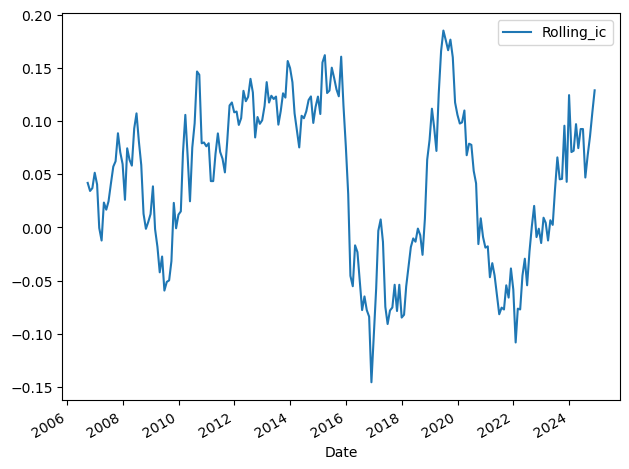

In [17]:
Ave_returns.loc[0:228].plot(x='Date',y=['Rolling_ic'])

plt.tight_layout()
plt.show()

In [18]:
Overall_ic

0.04787043318086315

In [19]:
import pyfolio as pf

ModuleNotFoundError: No module named 'pyfolio'

In [ ]:
benchmark_rets = Ave_returns.pop("Universe")
portfolio_returns = averages['S_hf_returns']

In [ ]:
pf.create_full_tear_sheet(portfolio_returns, benchmark_rets=benchmark_rets)